# Pairs of Shoes

In this project, I will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of a model can have real-world applications: for example to help
people who are visually impaired to have more independence.

I have organised this project into 4 parts: 
1.   Data Preprocessing
2.   Modelling: two different convolutional net architectures
3.   Training
4.   Evaluation

The data for this project was collected by asking students at my university to 
click pictures of their shoes. From all the volunteered images, only the images 
that were clicked with an appropriate resolution were selected manually.




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim

## 1. Data Processing

The data is collected into 3 folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.

I've separated `test_w` and `test_m` so that I can track my model's performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's shoes.

I care about the accuracies of the two types of shoes seperately as each type
will produce their own intricacies in the data, due to the variations in colors,
styles and designs. As a result, if I measured both the accuracies together, my model may only be able to identify one type (by overfitting to that type's intricacies in the training set) and fail to idenitify the other type. But in this situation I would have no idea that this was the case. Hence, by testing the accuracies individually I can know how my model performs on each type.

First I will load the training and test data, and separate the training data into training and validation.
Creating the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which will
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes collected for that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

## Normalization & Standardization
As usual the pixel intensities are stored as an integer between 0 and 255.
I will divide the intensities by 255 so that I have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.

In [0]:
import glob
import pickle
import os
MAX_TRAIN_AND_VAL=113
TRAIN_SIZE=83
train_data=np.zeros((TRAIN_SIZE, 3,2,224,224,3))
valid_data=np.zeros((MAX_TRAIN_AND_VAL-TRAIN_SIZE, 3,2,224,224,3))
test_m=np.zeros((10, 3,2,224,224,3))
test_w=np.zeros((10, 3,2,224,224,3))
student_index={}
counters={'train':0, 'test_m':0, 'test_w':0}

def get_images_from_file(file):
  """
  This function collects all the images in the specified file and places
  them in the appropriate global array. ie: If the image was from the test file
  then it is appended to the test array.

  file: path to a file containing images
  """
  global train_data
  global valid_data
  global test_m
  global test_w

  folder = file.split("/")[-2]     # get the name of the parent folder
  current_count = counters[folder] # counter for number of items processed for each type
  filename = file.split("/")[-1]   # get the name of the .jpg file
  filename = filename.split("_")
  s_id = int(filename[0][1:])-1    # student id
  p_id = int(filename[1])-1        # pair id
  l_or_r = 0 if "left" in filename[2] else 1  #left or right shoe
  img = plt.imread(file)           # read the image as a numpy array
  
  if s_id in student_index.keys(): # if the first shoe of the pair is processed
    index = student_index[s_id]
  else:
    index = current_count
    student_index[s_id] = index
    counters[folder] +=1
  #assigning the images to the appropriate array:
  if "train" in folder:
    if index<TRAIN_SIZE:
      train_data[index,p_id,l_or_r,:,:,:] = (((img[:, :, :3])/255)-0.5)
    else:
      valid_data[index-TRAIN_SIZE,p_id,l_or_r,:,:,:]=(((img[:, :, :3])/255)-0.5)
  elif "test_m" in folder:
    test_m[index,p_id,l_or_r,:,:,:] = (((img[:, :, :3])/255)-0.5)
  elif "test_w" in folder:
    test_w[index,p_id,l_or_r,:,:,:] = (((img[:, :, :3])/255)-0.5)

def dump_as_pickle(data, path_to_data):
  pickle.dump(data,open(path_to_data, 'wb'))

def generate_datasets_from_path(path):
  """
  Given the path to all the data folders, generate and return the train, 
  validation and test arrays.
  """
  global train_data
  global valid_data
  global test_m
  global test_w
  # train, test_m, test_w
  for folder in ['train', 'test_m', 'test_w']:
    jpg_files = glob.glob(os.path.join(path, folder,"*.jpg"))
    png_files = glob.glob(os.path.join(path, folder,"*.png"))
    files = jpg_files + png_files
    for file in files:
      get_images_from_file(file)
    if "train" in folder:
      dump_as_pickle(train_data, path+'train.pkl')
      dump_as_pickle(valid_data, path+'valid.pkl')
      print('Created train and valid dataset')
    elif "test_m" in folder:
      dump_as_pickle(test_m, path+'test_m.pkl')
      print('Created test_m dataset')
    elif "test_w" in folder:
      dump_as_pickle(test_w, path+'test_w.pkl')
      print('Created test_w dataset')
  return train_data, valid_data, test_m, test_w


path = "/content/drive/My Drive/Colab Files/data/"
train_data, valid_data, test_m, test_w = generate_datasets_from_path(path)

Created train and valid dataset
Created test_m dataset
Created test_w dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


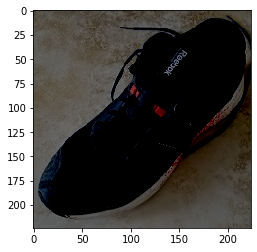

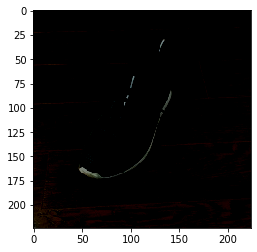

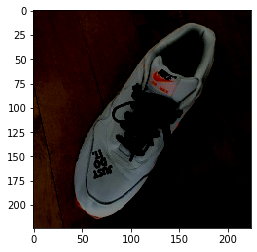

In [0]:
#Sampling images from the dataset to verify correctness.
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Creating Labeled Data

Since this is a supervised learning problem that determines whether two shoes come from the **same**
pair or **different** pairs, I need to create some labelled training data.
My model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, I will generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.

I will generate numpy arrays where each pair of shoes in the data set is
concatenated together. In particular, I'll be concatenating together images of left
and right shoes along the **height** axis.

To create negative training examples each image will contain 2 shoes from a **different** pair, but submitted
by the **same person**. 

Theoretically, for each persons image submissions, there are 6 different combinations
of "wrong pairs" that I could produce (since at most pairs were collected from
a single person). But to keep my data set *balanced*, I will
only produce **three** combinations of wrong pairs per unique person. Otherwise
the number of negative examples would be greater than the number of positive examples. In this case my model would not learn the features of shoes that are actually from the same pair, and as a result would classify almost all shoes as being different pairs. It would essentially overfit to shoes from different pairs and have low generalization. Hence, my model may become biased towards shoes that are different, and not be good at detecting if shoes come from the same pair. This problem of ensuring balanced datasets is critical to all classification problems.

Additionally, the reason I chose to use different shoes from the same person is
because different pairs from each person will all have the same background and lighting.
This will allow my model to learn the differences in the actual shoes to differentiate pairs of shoes rather than differences in backgrounds or lightings.

(83, 3, 2, 224, 224, 3)
(249, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


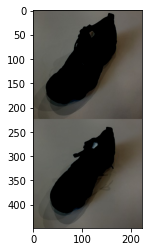

In [0]:
def generate_pair(data, different=False):
  """
  Given a dataset containing images of individual shoes, return a dataset with
  same pair shoes concatenated together in the default case, and shoes from 
  different pairs concatenated together otherwise.
  """
  new_data = np.zeros((data.shape[0]*3,448, 224, 3))
  for student_id in range(data.shape[0]):
    for pair_id in range(3):
      left_shoe = data[student_id, pair_id,0,:,:,:]
      pair_id = (pair_id+1)%3 if different else pair_id
      right_id = 0 if (different and student_id%2==0) else 1
      right_shoe = data[student_id, pair_id,right_id,:,:,:]
      new_data[(student_id*3)+pair_id,:,:,:] = (np.concatenate(np.array((left_shoe, right_shoe)), axis=0))
  new_data = new_data.reshape((data.shape[0]*3, 448,224,3))
  return new_data

def generate_same_pair(data):
  return generate_pair(data)

# Sanity Checks
print(train_data.shape)
print(generate_same_pair(train_data).shape)
plt.imshow(generate_same_pair(train_data)[0])# should show 2 shoes from the same pair

(83, 3, 2, 224, 224, 3)
(249, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


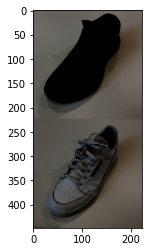

In [0]:
def generate_different_pair(data):
  return generate_pair(data, different=True)

# Sanity Checks
print(train_data.shape)
print(generate_different_pair(train_data).shape)
plt.imshow(generate_different_pair(train_data)[2]) # should show 2 shoes from different pairs

## 2. Convolutional Neural Network Architectures (with Pytorch)

As mentioned I will implement two different network architectures and will evaluate both to find which architecture works best.

The first architecture is as described above, where the images are concatenated
along the height axis. The second architecture contains the same layers as
in the first, but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, I will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension. To make this more clear, I have a simple graphic, attached below:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

In [0]:
# ARCHITECTURE 1
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.n=n
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n,
                               kernel_size=5,
                               padding=2)
        self.bn1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=(n*2),
                               kernel_size=5,
                               padding=2)
        self.bn2 = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=(n*2),
                               out_channels=(n*4),
                               kernel_size=5,
                               padding=2)
        self.bn3 = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=(n*4),
                               out_channels=(n*8),
                               kernel_size=5,
                               padding=2)
        self.bn4 = nn.BatchNorm2d(n*8)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.n*8 * 28 * 14, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.bn4(x)
        x = x.view(-1, self.n*8 * 28 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [0]:
# ARCHITECTURE 2
class CNNChannel(nn.Module):
    def __init__(self, n=4, dropout=False):
        super(CNNChannel, self).__init__()
        self.n=n
        self.dropout=dropout
        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=5,
                               padding=2)
        self.bn1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=(n*2),
                               kernel_size=5,
                               padding=2)
        self.bn2 = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=(n*2),
                               out_channels=(n*4),
                               kernel_size=5,
                               padding=2)
        self.bn3 = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=(n*4),
                               out_channels=(n*8),
                               kernel_size=5,
                               padding=2)
        self.bn4 = nn.BatchNorm2d(n*8)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(p=0.2) 
        self.drop2 = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(self.n*8 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        new_x0 = np.array((x.shape[0], 3, 224, 224))
        new_x1 = np.array((x.shape[0], 3, 224, 224))
        new_x0=x[:,:,:224]
        new_x1=x[:,:,224:]
        x = torch.cat((new_x1,new_x0),1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        if self.dropout:
          x = self.drop1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        if self.dropout:
          x = self.drop1(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        if self.dropout:
          x = self.drop2(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.bn4(x)
        if self.dropout:
          x = self.drop2(x)
        x = x.view(-1, self.n*8 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

**NOTES**

Although my task is a binary classification problem, I will still use the architecture
of a multi-class classification problem. That is, I'll use a one-hot vector to represent
my target. I'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is sometimes considered a standard practice in machine learning because
this architecture usually performs better one reason is because it has more weights and biases and hence more capacity! Additionally, since I use ReLu activations (in the hidden layers), using the Sigmoid activation can potentially blow up ReLu values (leading to exploding gradients) while Softmax generally works better with this.


Also, I will seperately compute the model's accuracy on positive and negative samples because I want to make sure that my model is just as accurate on both positive and negative examples.
This allows me to check that my model does not frequently do worse in one case
than the other. 
Addtionally, the true/false positive and negative rates are used to calculate
the Precision and Recall of my model to better evalauate its performance.

In [0]:
def get_accuracy(model, data, batch_size=50):
    """
    Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    # Positives
    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size])
        xs = xs.transpose(1,2).transpose(1,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()

    # Negatives
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size])
        xs = xs.transpose(1,2).transpose(1,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## 3. Training My Models

Since my positive and negative training sets are separate, it is actually easier for
me to generate separate minibatches of positive and negative training data! In
each iteration, I'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. I will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Since the training function is little lengthy, I will summarize my algorithm here:
- my loss function is Cross Entropy and my choice of optimizer is AdamW (with weight decay)
- first I obtain the positive and negative samples
- I shuffle the positive and negative samples at the start of each epoch
- at each iteration, I take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as my input for this batch
- in each iteration, I take `np.ones(batch_size / 2)` as the labels for my positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for my negative samples
- conversion from numpy arrays to PyTorch tensors
- computing the forward and backward passes
- after every epoch, I checkpoint my model 
- after every epoch, I report the accuracies for the training set and validation set
- finally, I track the training curve information and plot the training curve

In [0]:
from sklearn.utils import shuffle as shuff
def train_model(model, train_data=train_data, valid_data=valid_data, 
                batch_size=50, learning_rate=0.001, weight_decay=0,
                max_iters=1000, es=False, es_patience=15, lr_decay=False,
                lr_decay_factor=0.9, lr_decay_patience=3, checkpoint_path=None):
  
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.AdamW(model.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)
                       

  # Decay the Learning Rate 
  # mode='max': look for the maximum validation accuracy to track
  # Patience: # of epochs with no improvement after which lr will be reduced
  # factor = decaying factor
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                mode='max', 
                                factor=lr_decay_factor, 
                                patience=lr_decay_patience, verbose=True)

  iters, losses, train_acc, val_acc = [], [], [], []
  train_acc_pos, train_acc_neg = [], []
  val_acc_pos, val_acc_neg = [], []
  iters_sub = []
  
  num_iterations = 0
  num_epochs=0
  early_stop=False
  no_improvement_count=0
  new_max=False

  data_pos = generate_same_pair(train_data)
  data_neg = generate_different_pair(train_data)

  while True:
    np.random.shuffle(data_pos)
    np.random.shuffle(data_neg)
    for i in range(0, train_data.shape[0],batch_size//2):
      if(i+(batch_size//2))>train_data.shape[0]:break
      
      # Take (batch_size/2) positive samples and (batch_size/2) negative samples
      x_pos = torch.Tensor(data_pos[i:i+(batch_size//2)])
      x_pos = x_pos.transpose(1,2).transpose(1,3)
      x_neg = torch.Tensor(data_neg[i:i+(batch_size//2)])
      x_neg = x_neg.transpose(1,2).transpose(1,3)
      xs = torch.cat((x_pos, x_neg))

      # Take labels for the positive and negative samples
      t_pos = torch.ones(batch_size // 2).long()
      t_neg = torch.zeros(batch_size // 2).long()
      ts = torch.cat((t_pos,t_neg))

      xs, ts = shuff(xs, ts)

      model.train()

      zs = model(xs)                # Compute prediction logit
      loss = criterion(zs, ts)      # Compute the total loss
      loss.backward()               # Compute updates for parameters
      optimizer.step()              # Apply updates to parameters
      optimizer.zero_grad()

      # Save training information for current iteration
      iters.append(num_iterations)
      loss=float(loss)/batch_size
      losses.append(loss)
      
      num_iterations+=1

    ### End of One Epoch
    num_epochs+=1

    if(checkpoint_path is not None) and num_iterations > 0:
      torch.save(model.state_dict(), checkpoint_path.format(num_iterations))

    # Reporting the accuracies for the training set and validation set
    iters_sub.append(num_iterations)

    tacc_pos, tacc_neg = get_accuracy(model, train_data, batch_size)
    train_acc_pos.append(tacc_pos)
    train_acc_neg.append(tacc_neg)
    tacc = np.mean([tacc_pos, tacc_neg])
    train_acc.append(tacc)

    vacc_pos, vacc_neg = get_accuracy(model, valid_data, batch_size)
    val_acc_pos.append(vacc_pos)
    val_acc_neg.append(vacc_neg)
    vacc = np.mean([vacc_pos, vacc_neg])
    val_acc.append(vacc)

    print("Iter {:}; Loss {:f}; Train Acc {:.0f}%; Val Acc {:.0f}%".format(
        num_iterations, loss, tacc*100, vacc*100))
    print("\t[Val Acc -- Pos: {:.0f}%, Neg: {:.0f}%]\
    [Train Acc -- Pos: {:.0f}%, Neg: {:.0f}%]".format(vacc_pos*100, 
    vacc_neg*100, tacc_pos*100, tacc_neg*100))

    # Decay learning rate once validation accuracy > 75%
    if lr_decay and max(val_acc)>.75:
      scheduler.step(vacc)

    # Early Stopping
    # If I have not improved the validation accuracy in the last
    # 'early stopping patience' iterations, then I stop training.
    # Simply, es_patience is the number of iterations with no improvement 
    # after which I stop training.
    if es and num_epochs>es_patience:
      new_max = False if max(val_acc[:num_epochs-es_patience]) > \
              max(val_acc[num_epochs-es_patience:]) else True
      
      no_improvement_count += 1 if not new_max else -no_improvement_count
      if no_improvement_count>=es_patience:
        early_stop=True
        break

    if num_iterations>=max_iters:
      break
  plot_learning_curve(iters, losses, iters_sub, train_acc_pos, 
                      train_acc_neg, val_acc_pos, val_acc_neg,
                      train_acc, val_acc)
  print('--'*40)
  if early_stop:
    print('\nEarly stopping: ',
      'Validation Accuracy has not improved in last %d epochs.'%early_stopping, 
      '\nBest Iteration: %d;'%iters_sub[np.argmax(val_acc)], 
      ' Best Validation Accuracy: {:.2f}%'.format(max(val_acc)*100))
  else:
    print("Final Training Accuracy: {:.2f}%".format(train_acc[-1]*100))
    print("Final Validation Accuracy: {:.2f}%\n".format(val_acc[-1]*100))
    print("Best Validation Accuracy: {:.2f}%\n".format(max(val_acc)*100))

def plot_learning_curve(iters, losses, iters_sub, train_acc_pos,
                        train_acc_neg, val_acc_pos, val_acc_neg,
                        train_acc, val_acc):
  """Plot learning curves"""
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title("Learning Curve: Training Loss per Iteration")
  plt.show()

  plt.title("Learning Curve: Positive & Negative Accuracy per Iteration")
  plt.plot(iters_sub, train_acc_pos, label="Train Positive")
  plt.plot(iters_sub, train_acc_neg, label="Train Negative")
  plt.plot(iters_sub, val_acc_pos, label="Validation Positive")
  plt.plot(iters_sub, val_acc_neg, label="Validation Negative")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("Learning Curve: Overall Accuracy per Iteration")
  plt.plot(iters_sub, train_acc, label="Train")
  plt.plot(iters_sub, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


This is something I like to do to test that my models are training as expected.
I train my models on very few data points to see if my models can memorize a very small subset of the training set (e.g. 5 images).
The goal here is for the model to overfit the small subset of the training set.
I expect to be able to achieve 90%+ accuracy relatively quickly (within ~30 or so iterations).

Iter 2; Loss 0.150025; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 4; Loss 0.607136; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 6; Loss 0.245065; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 8; Loss 0.406886; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 10; Loss 0.298286; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 0%, Neg: 100%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 12; Loss 0.190367; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 0%, Neg: 100%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 14; Loss 0.208334; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 0%, Neg: 100%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 16; Loss 0.087782; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 3%, Neg: 97%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 18; Loss 0.373823; Train Acc 53%

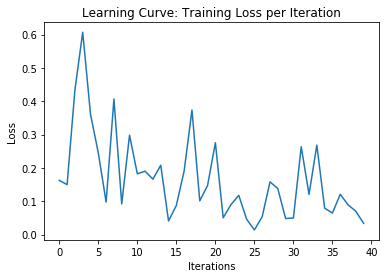

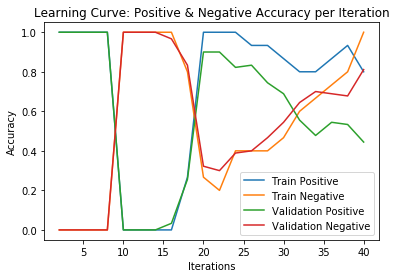

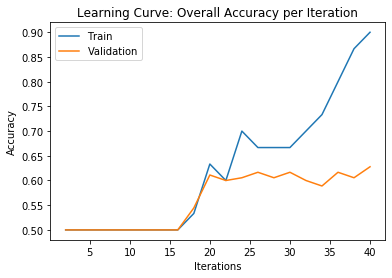

Final Training Accuracy: 90.00%
Final Validation Accuracy: 62.78%



In [0]:
model = CNNChannel()
train_model(model, train_data=train_data[:5], valid_data=valid_data, 
            batch_size=4, max_iters=40, learning_rate=0.001, 
            checkpoint_path=None)

Iter 1; Loss 0.091469; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 2; Loss 0.115819; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 3; Loss 0.089596; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 4; Loss 0.103562; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 5; Loss 0.106205; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 6; Loss 0.130413; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 7; Loss 0.103669; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 8; Loss 0.066159; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 9; Loss 0.098305; Train Acc 50%; Va

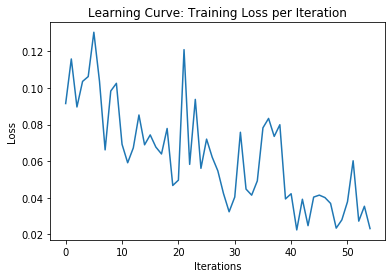

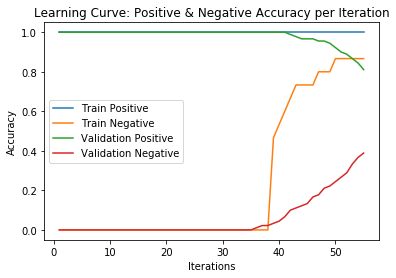

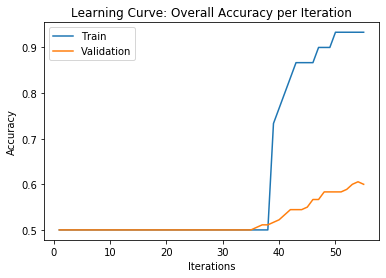

Final Training Accuracy: 93.33%
Final Validation Accuracy: 60.00%



In [0]:
model = CNN(2)
train_model(model, train_data=train_data[:5],valid_data=valid_data,
            batch_size=7, max_iters=55, learning_rate=0.0001,
            checkpoint_path=None)

# Comparing The Two Architectures

I expect, the CNNChannel model to perform better than the CNN model. This is because in the CNNChannel architecture I take each image's RGB color pixels as its own
channel. Whereas in the first architecture where each color channel has the 
pixels from both images. What this means is that I can detect features and 
patterns for each image independently and then predict whether or not they come
from the same pair. When I try to learn the feature maps for each color of both
the images together I will essentially be extracting less information from each
image as the weights for each feature map must be the same for each image. But
when I have the images split along the channel axis I can learn seperate 
weight mappings for each image and detect more patterns in each channel and as a 
result better predict whether two shoes come from the same pair or not. 
This can
be additionally understood as while the two models have almost the same number of 
parameters, when the images are concatenated along the height axis the maps are
learning weights for both images at the same time, but when the images are along
the channels axis, the parameters are split between channels and learning, 
individually, the features of each image.

# Hyperparameter Tuning

An explanation of how I approached tuning my hyperparameters. I first started by varying the learning between 1 and 1e-5 (multiplying by a
factor of 1/10 each time), while keeping the remaining hyperparameters constant 
at default values of batch_size=25, n=4, max_iters=500. I found the learning
of 0.001 to be the best suited, since my loss was gradually descreasing 
without any huge jumps to the upside between epochs. 

Next, I varied the batch_size while keep the remaining hyperparameters
constant. I decided to vary my batch size between 10 and 50 in increaments of
10, as I did not see significant improvements in my validation accuracy above
batch_size=50, yet as expected, I noticed significantly slower computational
times. I found a batch_size of 35 to be the best for CNN and batch_size of 25
for CNN Channel.
Next, in order to find the optimal capacity of the model I varied n. This
parameter controls the number of feature maps in my convolutional layers.
I found that increasing n beyond 12 lead to extremely slow computations as 
the number of parameters increased significantly. However, it also started  leading to the model overfitting the noise in the dataset. At n values below
6 I noticed a decrease in my validation accuracy as well as an increase in
the loss. I found n=10 works best for the CNNChannel mode and n=8 for the CNN
model, this was the best trade off between capacity, speed, and generalization 
for my model.

Additionally, as I increased to n=10, I found that my model was tending to
overfit the training data. In order to combat this, I increased the weight
decay to 1e-4 and introduced dropout. I applied dropout after each
layer with varying probabilities. Since I do not want a lot neurons to be
deactivated after the first and second I layers (since the number of nodes 
are lower), the probability was set to 0.3 and after the third and fourth 
CNN layer I drop neurons with a probability of 0.4. This Bagging like
technique helped improve my generalization significantly. 

However, I now noticed that my model's loss was seeing a high amount of 
fluctuations during training due to the stochasticity of gradients, so I 
combatted this by using learning rate decay. I decayed my learning rate once the
model had reached a minimum validation accuracy of 75% and then continue to
decay everytime the model's Validation accuracy does not increase for 5 
epochs.

I trained my model for 550 iterations as I saw that my models Training and 
Validation accuracy plateu around here for CNN Channel and at 250 for CNN.


***NOTE: I use weight decay, learning rate decay and drop out only on the
CNNChannel model. I found the CNN model works better without these additional
regularization techniques.

Iter 4; Loss 0.045492; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 100%, Neg: 0%]    [Train Acc -- Pos: 100%, Neg: 0%]
Iter 8; Loss 0.032921; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 0%, Neg: 100%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 12; Loss 0.023143; Train Acc 49%; Val Acc 49%
	[Val Acc -- Pos: 78%, Neg: 20%]    [Train Acc -- Pos: 78%, Neg: 21%]
Iter 16; Loss 0.019769; Train Acc 51%; Val Acc 51%
	[Val Acc -- Pos: 17%, Neg: 86%]    [Train Acc -- Pos: 28%, Neg: 74%]
Iter 20; Loss 0.022244; Train Acc 50%; Val Acc 49%
	[Val Acc -- Pos: 97%, Neg: 2%]    [Train Acc -- Pos: 96%, Neg: 4%]
Iter 24; Loss 0.026124; Train Acc 49%; Val Acc 51%
	[Val Acc -- Pos: 37%, Neg: 64%]    [Train Acc -- Pos: 49%, Neg: 50%]
Iter 28; Loss 0.023573; Train Acc 50%; Val Acc 51%
	[Val Acc -- Pos: 71%, Neg: 31%]    [Train Acc -- Pos: 71%, Neg: 29%]
Iter 32; Loss 0.019776; Train Acc 51%; Val Acc 48%
	[Val Acc -- Pos: 39%, Neg: 58%]    [Train Acc -- Pos: 37%, Neg: 64%]
Iter 36; Loss 0.024979; Train Acc 50

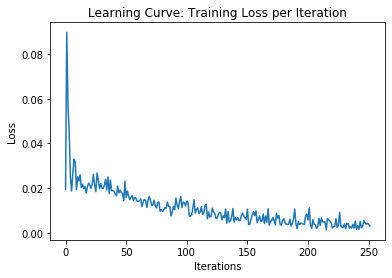

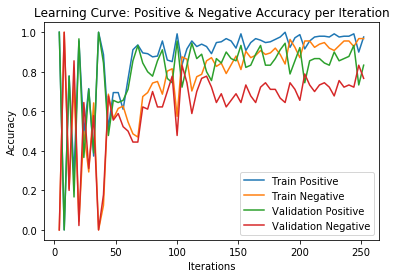

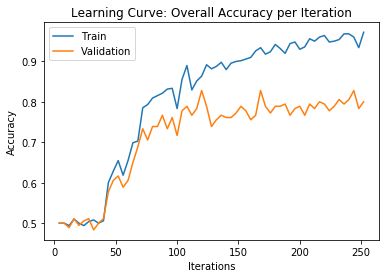

Final Training Accuracy: 97.19%
Final Validation Accuracy: 80.00%

CNN(8): LR: 0.001, Batch Size: 35, Max Iterations: 250


In [0]:
n=8
lr = 0.001
bs = 35
m_iters = 250
cnnchannel_checkpoint='/content/drive/My Drive/CNN/ckpt-{}.pk'
model = CNN(n)
train_model(model, train_data=train_data,
                valid_data=valid_data, batch_size=bs, max_iters=m_iters, 
                learning_rate=lr, checkpoint_path=cnnchannel_checkpoint)
print('CNN({}): LR: {}, Batch Size: {}, Max Iterations: {}'.format(n, lr,
                                                                    bs,m_iters))

Iter 6; Loss 0.071045; Train Acc 50%; Val Acc 50%
	[Val Acc -- Pos: 0%, Neg: 100%]    [Train Acc -- Pos: 0%, Neg: 100%]
Iter 12; Loss 0.054821; Train Acc 50%; Val Acc 48%
	[Val Acc -- Pos: 91%, Neg: 6%]    [Train Acc -- Pos: 95%, Neg: 5%]
Iter 18; Loss 0.034938; Train Acc 48%; Val Acc 51%
	[Val Acc -- Pos: 69%, Neg: 32%]    [Train Acc -- Pos: 59%, Neg: 37%]
Iter 24; Loss 0.028853; Train Acc 51%; Val Acc 52%
	[Val Acc -- Pos: 96%, Neg: 9%]    [Train Acc -- Pos: 98%, Neg: 3%]
Iter 30; Loss 0.025109; Train Acc 51%; Val Acc 52%
	[Val Acc -- Pos: 99%, Neg: 4%]    [Train Acc -- Pos: 100%, Neg: 2%]
Iter 36; Loss 0.023881; Train Acc 55%; Val Acc 53%
	[Val Acc -- Pos: 93%, Neg: 12%]    [Train Acc -- Pos: 99%, Neg: 10%]
Iter 42; Loss 0.025253; Train Acc 60%; Val Acc 59%
	[Val Acc -- Pos: 99%, Neg: 19%]    [Train Acc -- Pos: 100%, Neg: 21%]
Iter 48; Loss 0.023308; Train Acc 69%; Val Acc 66%
	[Val Acc -- Pos: 96%, Neg: 36%]    [Train Acc -- Pos: 92%, Neg: 45%]
Iter 54; Loss 0.050406; Train Acc 72%

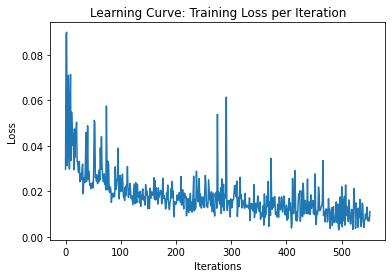

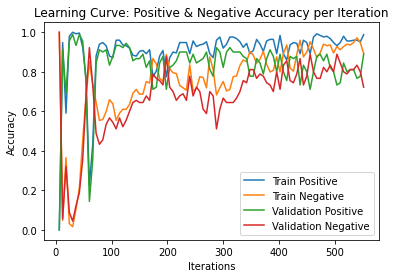

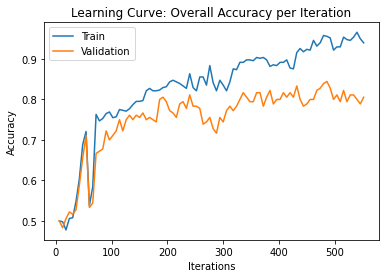

--------------------------------------------------------------------------------
Final Training Accuracy: 93.98%
Final Validation Accuracy: 80.56%

Best Validation Accuracy: 84.44%

CNNChannel(10): LR: 0.0015, Batch Size: 25, Weight Decay: 0.0001


In [0]:
n = 10
wd = 1e-4
lr = 0.0015
bs = 25
m_iters = 550
lr_factor = 0.95
lr_patience = 5
cnnchannel_checkpoint='/content/drive/My Drive/CNNChannel/ckpt-{}.pk'
model = CNNChannel(n, True)
train_model(model, train_data=train_data,
                valid_data=valid_data, batch_size=bs, max_iters=m_iters,
                lr_decay=True, lr_decay_patience=lr_patience, 
                lr_decay_factor=lr_factor, weight_decay=wd, learning_rate=lr, 
                checkpoint_path=cnnchannel_checkpoint)
print('CNNChannel({}): LR: {}, Batch Size: {}, Weight Decay: {}'.format(
    n, lr, bs,wd))

## Evaluating My Models

Accuracies of my **single best** model, is reported separately for the two test sets.

In [0]:
cnnchannel_best_checkpoint='/content/drive/My Drive/CNNChannel/ckpt-486.pk'
checkpoint = torch.load(cnnchannel_best_checkpoint)
best_model = CNNChannel(n, True)
best_model.load_state_dict(checkpoint)
test_m_pos, test_m_neg = get_accuracy(best_model, test_m, bs)
test_w_pos, test_w_neg = get_accuracy(best_model, test_w, bs)
acc_txt='{:} Accuracy -- Overall: {:.2f}%; Positive: {:.2f}%; Negative: {:.2f}%'
print(acc_txt.format('Test_m', np.mean([test_m_pos, test_m_neg])*100, 
                     test_m_pos*100, test_m_neg*100))
print(acc_txt.format('Test_w', np.mean([test_w_pos, test_w_neg])*100, 
                     test_w_pos*100, test_w_neg*100))

Test_m Accuracy -- Overall: 76.67%; Positive: 76.67%; Negative: 76.67%
Test_w Accuracy -- Overall: 85.00%; Positive: 93.33%; Negative: 76.67%


From the test sets one set of men's shoes and one set of women's shoes that my model correctly classified as being from the same pair are shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


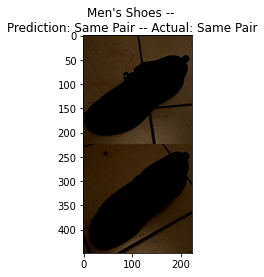

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


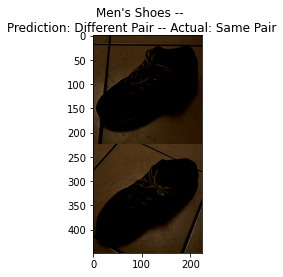

In [0]:
def make_pred_and_plot_image(model, images, return_correct=True, mens_shoe=True):
  for image in images:
    image1=image.reshape((1, 448, 224, 3))
    xs = torch.Tensor(image1)
    xs = xs.transpose(1,2).transpose(1,3)
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if (pred==1 and return_correct) or (pred==0 and not return_correct):
      pred_t = 'Prediction: Same Pair' if pred==1 else 'Prediction: Different Pair'
      shoe_type = 'Men\'s Shoes -- \n' if mens_shoe else 'Women\'s Shoes -- \n'
      true_label = 'Actual: Same Pair'
      plt.figure()
      plt.imshow(image)
      plt.suptitle(shoe_type+pred_t+' -- '+true_label)
      plt.show()
      return

# Men's shoe classified correctly
make_pred_and_plot_image(best_model, generate_same_pair(test_m), True)
# Men's shoe classified incorrectly
make_pred_and_plot_image(best_model, generate_same_pair(test_m), False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


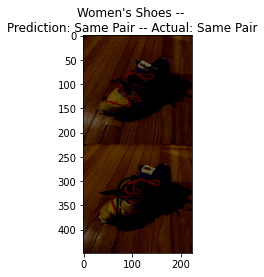

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


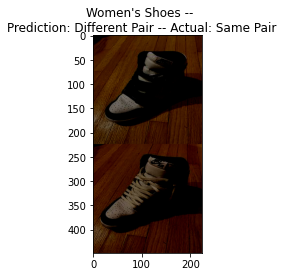

In [0]:
# Women's shoe classified correctly
make_pred_and_plot_image(best_model, generate_same_pair(test_w), True, False)
# Women's shoe classified incorrectly
make_pred_and_plot_image(best_model, generate_same_pair(test_w), False, False)